In [1]:
%pylab inline
import numpy as np
import sklearn.linear_model as linear
import sklearn.model_selection as selection
from sklearn.model_selection import StratifiedKFold, KFold
import sklearn.metrics as metrics
import sklearn.datasets as datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch as th
import torch.nn as nn
import torch.optim as optim

import scipy.stats as stats
import pandas as pd
#https://www.kaggle.com/super13579/pytorch-nn-cyclelr-k-fold-0-897-lightgbm-0-899

Populating the interactive namespace from numpy and matplotlib


In [2]:
columns=['id','thickness','uniformity_cell_size','uniformity_cell_shape','marginal_adhesion','single_epithelial_cell_size','bare_nuclei','bland_chromatin','normal_nucleoli','mitoses','class']
X = pd.read_csv('breast-cancer-wisconsin.data',names=columns,na_values=['?'])
#X = pd.read_csv('breast-cancer-wisconsin.data')

In [3]:
print(X.isnull().sum())
print(X.isnull().values.any())
print(X.isnull().sum().sum())
#Replace using median
median = X['bare_nuclei'].median()
X['bare_nuclei'].fillna(median, inplace=True)

id                              0
thickness                       0
uniformity_cell_size            0
uniformity_cell_shape           0
marginal_adhesion               0
single_epithelial_cell_size     0
bare_nuclei                    16
bland_chromatin                 0
normal_nucleoli                 0
mitoses                         0
class                           0
dtype: int64
True
16


In [4]:
print(X.head())
print(X.shape)
X.drop(X.columns[0],axis=1,inplace=True)
y = X['class']
X.drop(['class'], axis=1, inplace=True)
print(X.head())
print(X.shape)

        id  thickness  uniformity_cell_size  uniformity_cell_shape  \
0  1000025          5                     1                      1   
1  1002945          5                     4                      4   
2  1015425          3                     1                      1   
3  1016277          6                     8                      8   
4  1017023          4                     1                      1   

   marginal_adhesion  single_epithelial_cell_size  bare_nuclei  \
0                  1                            2          1.0   
1                  5                            7         10.0   
2                  1                            2          2.0   
3                  1                            3          4.0   
4                  3                            2          1.0   

   bland_chromatin  normal_nucleoli  mitoses  class  
0                3                1        1      2  
1                3                2        1      2  
2                3  

In [5]:
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
y = pd.DataFrame(data=y, columns=['class'])

In [6]:
sc = StandardScaler()
X = sc.fit_transform(X)
X = np.array(X)
y = np.array(y)

In [7]:
class MoonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = nn.BCELoss()
        
    def forward(self, X):
        return None 
    
    def loss(self, X, y):
        probs = self.forward(X)
        return self.loss_func(probs, y)
    
    def predict_proba(self, X, as_numpy=False):
        res = self.forward(X)
        if as_numpy:
            res = res.detach().numpy()
        return res
    
    def predict(self, X, threshold=0.5, as_numpy=False):
        probs = self.predict_proba(X, as_numpy)
        return probs > threshold
    
    def fit(self, X, y, epochs=1000, lr=0.1, lam=0):
        optimizer = optim.RMSprop(self.parameters(), lr=lr)
        loss_curve = []
        for _ in range(epochs):
            optimizer.zero_grad()
            loss_val = self.loss(X, y) + self.regularize(lam)
            loss_curve.append(loss_val.data.item())
            loss_val.backward()
            optimizer.step()
        return loss_curve
    
    def regularize(self, lam):
        loss_val = 0
        for p in self.parameters():
            loss_val += lam * th.norm(p)
        return loss_val

In [8]:
class NNModel1(MoonModel):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(9, 2, bias=True)
        self.act1 = nn.Sigmoid()
        self.l2 = nn.Linear(2, 1, bias=True)
        self.act2 = nn.Sigmoid()
        
    
    def forward(self, X):
        res = self.l1(X)
        res = self.act1(res)
        res = self.l2(res)
        res = self.act2(res)
        return res

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

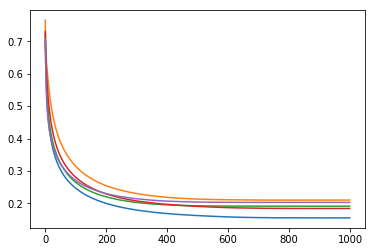

In [9]:
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)

f1_lr  = []
accuracy_lr = []
tpr_lr = []
tnr_lr = []

f1_nn = []
accuracy_nn = []
tpr_nn = []
tnr_nn = []

def plot_loss(loss_curve):
    plt.plot(list(range(len(loss_curve))), loss_curve)


for train_idx, test_idx in kf.split(X):
    
    X_train_fold = th.tensor(X[train_idx.astype(int)],dtype=th.float)
    #print(y[train_idx])
    y_train_fold = th.tensor(y[train_idx.astype(int)],dtype=th.float)
    X_test_fold = th.tensor(X[test_idx.astype(int)],dtype=th.float)
    #print(y[test_idx])
    y_test_fold = th.tensor(y[test_idx.astype(int)],dtype=th.float)
    
    #X_train = th.tensor(X_train, dtype=th.float32)
    #X_test = th.tensor(X_test, dtype=th.float32)
    #y_train = th.tensor(y_train, dtype=th.float32).view(-1, 1)
    #y_test = th.tensor(y_test, dtype=th.float32).view(-1, 1)
    
    lr = linear.LogisticRegression(solver='lbfgs')
    lr.fit(X_train_fold, y_train_fold)
    predictions = lr.predict(X_test_fold)
    probs = lr.predict_proba(X_test_fold)[:,1]
    f1_lr.append(metrics.f1_score(y_test_fold, predictions))
    accuracy_lr.append(metrics.accuracy_score(y_test_fold, predictions))
    tpr_lr.append(metrics.recall_score(y_test_fold, predictions))
    tn, fp, fn, tp = metrics.confusion_matrix(y_test_fold, predictions).ravel()
    N = tn+fp
    tnr_lr.append(tn/N)
    
    
    
    nn_1 = NNModel1()
    # since this model is more complex, we use a smaller learning rate 
    # and use regularization to prevent overfitting
    curve = nn_1.fit(X_train_fold, y_train_fold, lr=0.008, lam=0.01)
    plot_loss(curve)
    predictions = nn_1.predict(X_test_fold, as_numpy=True)
    #print(predictions)
    f1_nn.append(metrics.f1_score(y_test_fold, predictions))
    accuracy_nn.append(metrics.accuracy_score(y_test_fold, predictions))
    tpr_nn.append(metrics.recall_score(y_test_fold, predictions))
    tn, fp, fn, tp = metrics.confusion_matrix(y_test_fold, predictions).ravel()
    N = tn+fp
    tnr_nn.append(tn/N)

In [10]:
print(np.mean(f1_nn))
print(np.mean(accuracy_nn))
print(np.mean(tpr_nn))
print(np.mean(tnr_nn))

0.9558132956152757
0.9685405960945529
0.9605555555555556
0.9737681159420291


In [11]:
print(np.mean(f1_lr))
print(np.mean(accuracy_lr))
print(np.mean(tpr_lr))
print(np.mean(tnr_lr))

0.955518744805261
0.9685405960945529
0.9565555555555555
0.9759420289855072


In [12]:
stats.ttest_rel(f1_lr, f1_nn)

Ttest_relResult(statistic=-0.0893043135389695, pvalue=0.9331328175469775)

Using a significane level of 0.05 and the f1_score we see that the difference between the logistic regression model and the neural network model are not statistically significant. 